In [2]:
import os
os.chdir("..")
from packages.data_objects.dataset import TorchH5Dataset, autoencoder_unpack_func
from packages.io.torch_dataloaders import get_data_loaders
dataset = TorchH5Dataset(h5_path='/media/lolly/SSD/motor_eeg_dataset/motor_eeg_dataset.h5', unpack_func=autoencoder_unpack_func)
train_loader, _, _ = get_data_loaders(dataset, norm_axes=(0,2), target_norm_axes=(0,2), norm_convergence_threshold=1e-3, batch_size=64)
batch = next(iter(train_loader))

Calculating normalization parameters (input & target):  98%|█████████▊| 39/40 [00:02<00:00, 18.95it/s, samples=5120, input_conv=0, target_conv=0]
/home/lolly/Projects/MIEEG/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [3]:
from packages.models.vqae_light_ts import VQAELight, VQAELightConfig
config = VQAELightConfig(embedding_dim=512, use_quantizer=False)
model = VQAELight(config)

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

from packages.train.loss import VQAE23Loss
# ============================================================================
# SINGLE BATCH SANITY CHECK
# ============================================================================

# Get a single batch

input_data = batch['input'][0].unsqueeze(0)  # Remove batch dimension
target_data = batch['target'][0].unsqueeze(0)  # Remove batch dimension

print(f"Input shape: {input_data.shape}")
print(f"Target shape: {target_data.shape}")

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_data = input_data.to(device)
target_data = target_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = VQAE23Loss(mse_weight=1.0, phase_weight=0, magnitude_weight=0)
# Training on single batch
n_iterations = 1000
model.train()

print(f"\nTraining on single batch for {n_iterations} iterations...")

for i in tqdm(range(n_iterations)):
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    output = model(input_data)
    
    # Calculate loss
    recon_loss = loss_fn(output, {'target': target_data, 'input': input_data})
    
    
    # 
    # Backward pass
    recon_loss['loss'].backward()
    optimizer.step()
    
    # Print every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"\nIteration {i+1}/{n_iterations}")
        print(f"  Reconstruction Loss: {recon_loss}")
        print(f"MSE Loss: {F.mse_loss(output['reconstruction'], target_data).item():.6f}")

print("\n✓ Sanity check complete!")
print(f"Final Reconstruction Loss: {recon_loss['loss'].item():.6f}")
print(f"Loss should be decreasing - model can overfit a single batch!")

Input shape: torch.Size([1, 32, 640])
Target shape: torch.Size([1, 32, 640])

Training on single batch for 1000 iterations...


  1%|          | 11/1000 [00:02<03:12,  5.15it/s]


Iteration 10/1000
  Reconstruction Loss: {'loss': tensor(1.7564, grad_fn=<AddBackward0>), 'mse_loss': tensor(5.4677, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1618, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.4719, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9676, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0684, grad_fn=<AddBackward0>)}
MSE Loss: 5.467695


  2%|▏         | 20/1000 [00:04<03:52,  4.21it/s]


Iteration 20/1000
  Reconstruction Loss: {'loss': tensor(1.7140, grad_fn=<AddBackward0>), 'mse_loss': tensor(5.8198, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1393, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.3761, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9683, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0962, grad_fn=<AddBackward0>)}
MSE Loss: 5.819797


  3%|▎         | 31/1000 [00:06<03:18,  4.87it/s]


Iteration 30/1000
  Reconstruction Loss: {'loss': tensor(1.6555, grad_fn=<AddBackward0>), 'mse_loss': tensor(6.6674, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1360, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.2829, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9607, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0899, grad_fn=<AddBackward0>)}
MSE Loss: 6.667421


  4%|▍         | 41/1000 [00:09<03:16,  4.89it/s]


Iteration 40/1000
  Reconstruction Loss: {'loss': tensor(1.6471, grad_fn=<AddBackward0>), 'mse_loss': tensor(6.1146, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1434, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.2806, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9614, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0750, grad_fn=<AddBackward0>)}
MSE Loss: 6.114614


  5%|▌         | 50/1000 [00:10<03:09,  5.02it/s]


Iteration 50/1000
  Reconstruction Loss: {'loss': tensor(1.6216, grad_fn=<AddBackward0>), 'mse_loss': tensor(6.0590, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1411, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.2706, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9492, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0604, grad_fn=<AddBackward0>)}
MSE Loss: 6.059023


  6%|▌         | 61/1000 [00:13<03:15,  4.81it/s]


Iteration 60/1000
  Reconstruction Loss: {'loss': tensor(1.6190, grad_fn=<AddBackward0>), 'mse_loss': tensor(6.3105, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1307, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.2957, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9523, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0547, grad_fn=<AddBackward0>)}
MSE Loss: 6.310472


  7%|▋         | 70/1000 [00:15<05:39,  2.74it/s]


Iteration 70/1000
  Reconstruction Loss: {'loss': tensor(1.6294, grad_fn=<AddBackward0>), 'mse_loss': tensor(6.3135, grad_fn=<MseLossBackward0>), 'magnitude_loss': tensor(1.1462, grad_fn=<MeanBackward0>), 'power_loss': tensor(0.3054, grad_fn=<MeanBackward0>), 'phase_loss': tensor(0.9423, grad_fn=<DivBackward0>), 'vq_loss': tensor(0.), 'bottleneck_loss': tensor(0.0478, grad_fn=<AddBackward0>)}
MSE Loss: 6.313538


  8%|▊         | 78/1000 [00:18<03:33,  4.32it/s]


KeyboardInterrupt: 

In [3]:
recon = output['reconstruction'].detach().cpu()

NameError: name 'output' is not defined

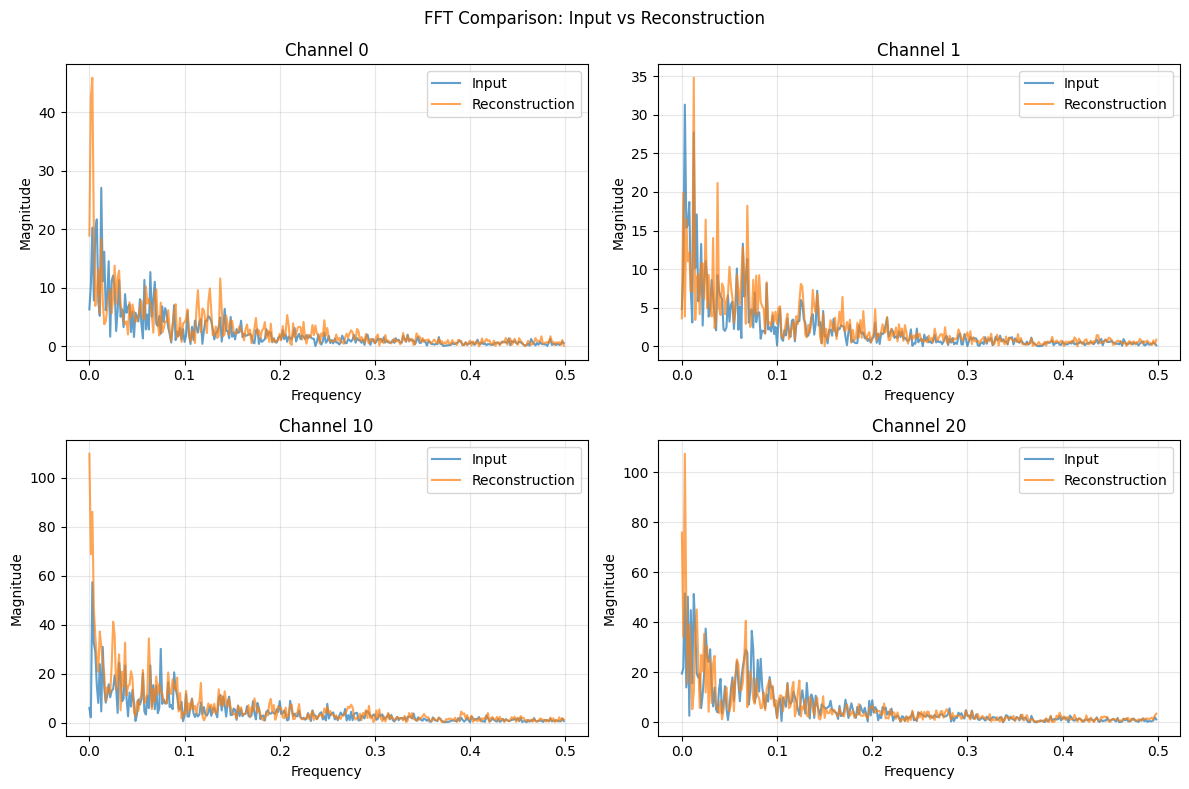

In [6]:
import numpy as np

import matplotlib.pyplot as plt

# Compute FFT for input and reconstruction
target_fft = np.fft.fft(target_data.squeeze().numpy(), axis=1)
recon_fft = np.fft.fft(recon.squeeze().numpy(), axis=1)

# Get frequencies
n_samples = target_data.shape[-1]
freqs = np.fft.fftfreq(n_samples)

# Plot magnitude spectrum for a few channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('FFT Comparison: Input vs Reconstruction')

channels_to_plot = [0, 1, 10, 20]  # Select a few channels to visualize

for idx, ch in enumerate(channels_to_plot):
    row = idx // 2
    col = idx % 2
    
    # Only plot positive frequencies
    pos_mask = freqs >= 0
    
    axes[row, col].plot(freqs[pos_mask], np.abs(target_fft[ch, pos_mask]), label='Input', alpha=0.7)
    axes[row, col].plot(freqs[pos_mask], np.abs(recon_fft[ch, pos_mask]), label='Reconstruction', alpha=0.7)
    axes[row, col].set_xlabel('Frequency')
    axes[row, col].set_ylabel('Magnitude')
    axes[row, col].set_title(f'Channel {ch}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

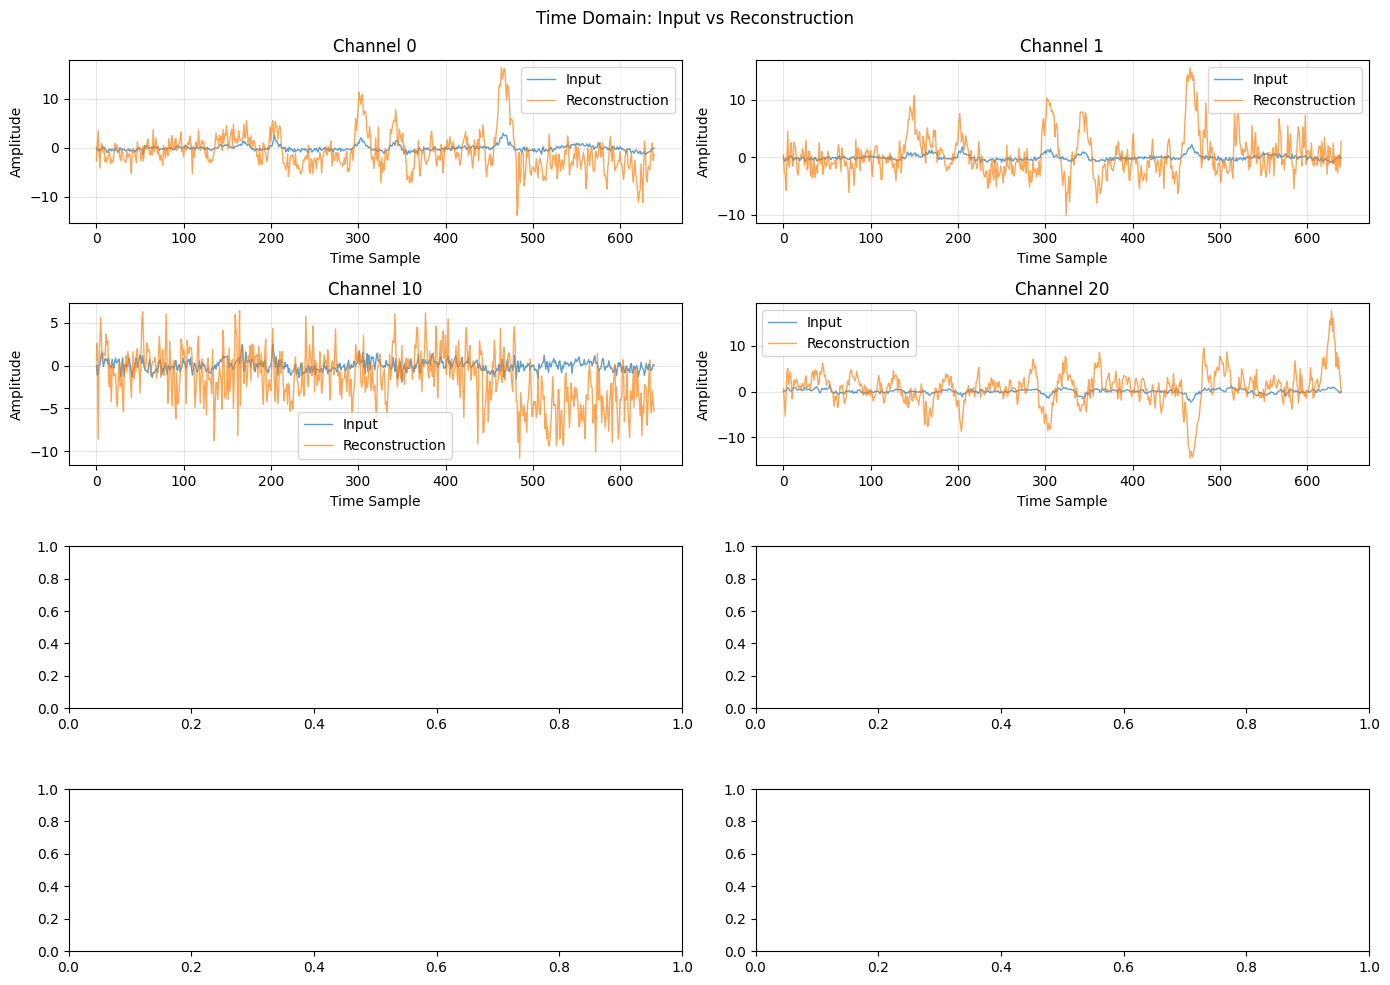

In [21]:
import matplotlib.pyplot as plt

# Plot time domain reconstruction vs input
fig, axes = plt.subplots(4, 2, figsize=(14, 10))
fig.suptitle('Time Domain: Input vs Reconstruction')

channels_to_plot = [0, 1, 10, 20]  # Use the same channels

for idx, ch in enumerate(channels_to_plot):
    row = idx // 2
    col = idx % 2
    
    # Plot input
    axes[row, col].plot(target_data.squeeze()[ch].numpy(), label='Input', alpha=0.7, linewidth=1)
    # Plot reconstruction
    axes[row, col].plot(recon.squeeze()[ch].numpy(), label='Reconstruction', alpha=0.7, linewidth=1)
    
    axes[row, col].set_xlabel('Time Sample')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].set_title(f'Channel {ch}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

from packages.train.loss import CustomMSE
# ============================================================================
# SINGLE BATCH SANITY CHECK
# ============================================================================

# Get a single batch

input_data = batch['input'][0].unsqueeze(0)  # Remove batch dimension
target_data = batch['target'][0].unsqueeze(0)  # Remove batch dimension

print(f"Input shape: {input_data.shape}")
print(f"Target shape: {target_data.shape}")

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_data = input_data.to(device)
target_data = target_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CustomMSE()
# Training on single batch
n_iterations = 1000
model.train()

print(f"\nTraining on single batch for {n_iterations} iterations...")

for i in tqdm(range(n_iterations)):
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    output = model(input_data)
    
    # Calculate loss
    recon_loss = loss_fn(output, {'target': target_data, 'input': input_data})
    
    
    # 
    # Backward pass
    recon_loss['loss'].backward()
    optimizer.step()
    
    # Print every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"\nIteration {i+1}/{n_iterations}")
        print(f"  Reconstruction Loss: {recon_loss}")
        # print(f"MSE Loss: {F.mse_loss(output['reconstruction'], target_data).item():.6f}")

print("\n✓ Sanity check complete!")
print(f"Final Reconstruction Loss: {recon_loss['loss'].item():.6f}")
print(f"Loss should be decreasing - model can overfit a single batch!")

Input shape: torch.Size([1, 32, 640])
Target shape: torch.Size([1, 32, 640])

Training on single batch for 1000 iterations...


  1%|          | 11/1000 [00:01<02:15,  7.28it/s]


Iteration 10/1000
  Reconstruction Loss: {'loss': tensor(1.6276, grad_fn=<MseLossBackward0>)}


  2%|▏         | 21/1000 [00:02<01:40,  9.75it/s]


Iteration 20/1000
  Reconstruction Loss: {'loss': tensor(1.5985, grad_fn=<MseLossBackward0>)}


  3%|▎         | 31/1000 [00:03<01:32, 10.45it/s]


Iteration 30/1000
  Reconstruction Loss: {'loss': tensor(1.5534, grad_fn=<MseLossBackward0>)}


  4%|▍         | 41/1000 [00:04<01:35, 10.02it/s]


Iteration 40/1000
  Reconstruction Loss: {'loss': tensor(1.4954, grad_fn=<MseLossBackward0>)}


  5%|▌         | 51/1000 [00:05<01:45,  9.00it/s]


Iteration 50/1000
  Reconstruction Loss: {'loss': tensor(1.4323, grad_fn=<MseLossBackward0>)}


  6%|▌         | 61/1000 [00:06<01:46,  8.86it/s]


Iteration 60/1000
  Reconstruction Loss: {'loss': tensor(1.3722, grad_fn=<MseLossBackward0>)}


  7%|▋         | 71/1000 [00:08<01:36,  9.63it/s]


Iteration 70/1000
  Reconstruction Loss: {'loss': tensor(1.3188, grad_fn=<MseLossBackward0>)}


  8%|▊         | 81/1000 [00:09<01:42,  8.98it/s]


Iteration 80/1000
  Reconstruction Loss: {'loss': tensor(1.2726, grad_fn=<MseLossBackward0>)}


  9%|▉         | 91/1000 [00:10<01:48,  8.35it/s]


Iteration 90/1000
  Reconstruction Loss: {'loss': tensor(1.2319, grad_fn=<MseLossBackward0>)}


 10%|█         | 101/1000 [00:11<01:38,  9.13it/s]


Iteration 100/1000
  Reconstruction Loss: {'loss': tensor(1.1965, grad_fn=<MseLossBackward0>)}


 11%|█         | 111/1000 [00:12<01:35,  9.35it/s]


Iteration 110/1000
  Reconstruction Loss: {'loss': tensor(1.1657, grad_fn=<MseLossBackward0>)}


 12%|█▏        | 121/1000 [00:13<01:36,  9.14it/s]


Iteration 120/1000
  Reconstruction Loss: {'loss': tensor(1.1378, grad_fn=<MseLossBackward0>)}


 13%|█▎        | 131/1000 [00:14<01:28,  9.84it/s]


Iteration 130/1000
  Reconstruction Loss: {'loss': tensor(1.1135, grad_fn=<MseLossBackward0>)}


 14%|█▍        | 141/1000 [00:15<01:22, 10.39it/s]


Iteration 140/1000
  Reconstruction Loss: {'loss': tensor(1.0922, grad_fn=<MseLossBackward0>)}


 15%|█▌        | 151/1000 [00:16<01:27,  9.65it/s]


Iteration 150/1000
  Reconstruction Loss: {'loss': tensor(1.0711, grad_fn=<MseLossBackward0>)}


 16%|█▌        | 161/1000 [00:18<02:13,  6.30it/s]


Iteration 160/1000
  Reconstruction Loss: {'loss': tensor(1.0527, grad_fn=<MseLossBackward0>)}


 17%|█▋        | 171/1000 [00:19<01:47,  7.75it/s]


Iteration 170/1000
  Reconstruction Loss: {'loss': tensor(1.0355, grad_fn=<MseLossBackward0>)}


 18%|█▊        | 181/1000 [00:20<01:44,  7.85it/s]


Iteration 180/1000
  Reconstruction Loss: {'loss': tensor(1.0213, grad_fn=<MseLossBackward0>)}


 19%|█▉        | 191/1000 [00:22<01:56,  6.94it/s]


Iteration 190/1000
  Reconstruction Loss: {'loss': tensor(1.0060, grad_fn=<MseLossBackward0>)}


 20%|██        | 201/1000 [00:23<01:53,  7.05it/s]


Iteration 200/1000
  Reconstruction Loss: {'loss': tensor(0.9930, grad_fn=<MseLossBackward0>)}


 21%|██        | 211/1000 [00:25<01:53,  6.96it/s]


Iteration 210/1000
  Reconstruction Loss: {'loss': tensor(0.9809, grad_fn=<MseLossBackward0>)}


 22%|██▏       | 221/1000 [00:26<01:56,  6.67it/s]


Iteration 220/1000
  Reconstruction Loss: {'loss': tensor(0.9716, grad_fn=<MseLossBackward0>)}


 23%|██▎       | 231/1000 [00:28<01:49,  7.00it/s]


Iteration 230/1000
  Reconstruction Loss: {'loss': tensor(0.9584, grad_fn=<MseLossBackward0>)}


 24%|██▍       | 241/1000 [00:30<02:28,  5.11it/s]


Iteration 240/1000
  Reconstruction Loss: {'loss': tensor(0.9502, grad_fn=<MseLossBackward0>)}


 25%|██▌       | 250/1000 [00:31<02:19,  5.36it/s]


Iteration 250/1000
  Reconstruction Loss: {'loss': tensor(0.9410, grad_fn=<MseLossBackward0>)}


 26%|██▌       | 261/1000 [00:33<02:04,  5.93it/s]


Iteration 260/1000
  Reconstruction Loss: {'loss': tensor(0.9315, grad_fn=<MseLossBackward0>)}


 27%|██▋       | 270/1000 [00:35<01:49,  6.68it/s]


Iteration 270/1000
  Reconstruction Loss: {'loss': tensor(0.9243, grad_fn=<MseLossBackward0>)}


 28%|██▊       | 281/1000 [00:36<01:47,  6.66it/s]


Iteration 280/1000
  Reconstruction Loss: {'loss': tensor(0.9161, grad_fn=<MseLossBackward0>)}


 29%|██▉       | 291/1000 [00:38<01:42,  6.90it/s]


Iteration 290/1000
  Reconstruction Loss: {'loss': tensor(0.9101, grad_fn=<MseLossBackward0>)}


 30%|███       | 301/1000 [00:39<01:31,  7.66it/s]


Iteration 300/1000
  Reconstruction Loss: {'loss': tensor(0.9023, grad_fn=<MseLossBackward0>)}


 31%|███       | 311/1000 [00:41<01:34,  7.26it/s]


Iteration 310/1000
  Reconstruction Loss: {'loss': tensor(0.8970, grad_fn=<MseLossBackward0>)}


 32%|███▏      | 321/1000 [00:42<01:34,  7.19it/s]


Iteration 320/1000
  Reconstruction Loss: {'loss': tensor(0.8917, grad_fn=<MseLossBackward0>)}


 33%|███▎      | 331/1000 [00:44<01:38,  6.79it/s]


Iteration 330/1000
  Reconstruction Loss: {'loss': tensor(0.8849, grad_fn=<MseLossBackward0>)}


 34%|███▍      | 341/1000 [00:45<01:33,  7.07it/s]


Iteration 340/1000
  Reconstruction Loss: {'loss': tensor(0.8797, grad_fn=<MseLossBackward0>)}


 35%|███▌      | 351/1000 [00:46<01:25,  7.58it/s]


Iteration 350/1000
  Reconstruction Loss: {'loss': tensor(0.8750, grad_fn=<MseLossBackward0>)}


 36%|███▌      | 361/1000 [00:48<01:29,  7.17it/s]


Iteration 360/1000
  Reconstruction Loss: {'loss': tensor(0.8727, grad_fn=<MseLossBackward0>)}


 37%|███▋      | 371/1000 [00:49<01:23,  7.53it/s]


Iteration 370/1000
  Reconstruction Loss: {'loss': tensor(0.8660, grad_fn=<MseLossBackward0>)}


 38%|███▊      | 381/1000 [00:51<01:27,  7.07it/s]


Iteration 380/1000
  Reconstruction Loss: {'loss': tensor(0.8618, grad_fn=<MseLossBackward0>)}


 39%|███▉      | 391/1000 [00:52<01:29,  6.82it/s]


Iteration 390/1000
  Reconstruction Loss: {'loss': tensor(0.8580, grad_fn=<MseLossBackward0>)}


 40%|████      | 401/1000 [00:54<01:24,  7.09it/s]


Iteration 400/1000
  Reconstruction Loss: {'loss': tensor(0.8556, grad_fn=<MseLossBackward0>)}


 41%|████      | 411/1000 [00:55<01:13,  8.03it/s]


Iteration 410/1000
  Reconstruction Loss: {'loss': tensor(0.8524, grad_fn=<MseLossBackward0>)}


 42%|████▏     | 421/1000 [00:56<01:10,  8.21it/s]


Iteration 420/1000
  Reconstruction Loss: {'loss': tensor(0.8483, grad_fn=<MseLossBackward0>)}


 43%|████▎     | 431/1000 [00:58<01:17,  7.30it/s]


Iteration 430/1000
  Reconstruction Loss: {'loss': tensor(0.8456, grad_fn=<MseLossBackward0>)}


 44%|████▍     | 441/1000 [00:59<01:15,  7.37it/s]


Iteration 440/1000
  Reconstruction Loss: {'loss': tensor(0.8424, grad_fn=<MseLossBackward0>)}


 45%|████▌     | 451/1000 [01:01<01:23,  6.55it/s]


Iteration 450/1000
  Reconstruction Loss: {'loss': tensor(0.8410, grad_fn=<MseLossBackward0>)}


 46%|████▌     | 461/1000 [01:02<01:15,  7.15it/s]


Iteration 460/1000
  Reconstruction Loss: {'loss': tensor(0.8410, grad_fn=<MseLossBackward0>)}


 47%|████▋     | 471/1000 [01:03<01:04,  8.19it/s]


Iteration 470/1000
  Reconstruction Loss: {'loss': tensor(0.8351, grad_fn=<MseLossBackward0>)}


 48%|████▊     | 481/1000 [01:05<01:13,  7.07it/s]


Iteration 480/1000
  Reconstruction Loss: {'loss': tensor(0.8326, grad_fn=<MseLossBackward0>)}


 49%|████▉     | 491/1000 [01:06<01:13,  6.95it/s]


Iteration 490/1000
  Reconstruction Loss: {'loss': tensor(0.8316, grad_fn=<MseLossBackward0>)}


 50%|█████     | 501/1000 [01:08<01:09,  7.19it/s]


Iteration 500/1000
  Reconstruction Loss: {'loss': tensor(0.8301, grad_fn=<MseLossBackward0>)}


 51%|█████     | 511/1000 [01:09<01:06,  7.36it/s]


Iteration 510/1000
  Reconstruction Loss: {'loss': tensor(0.8282, grad_fn=<MseLossBackward0>)}


 52%|█████▏    | 521/1000 [01:11<00:59,  8.08it/s]


Iteration 520/1000
  Reconstruction Loss: {'loss': tensor(0.8253, grad_fn=<MseLossBackward0>)}


 53%|█████▎    | 531/1000 [01:12<00:58,  7.98it/s]


Iteration 530/1000
  Reconstruction Loss: {'loss': tensor(0.8238, grad_fn=<MseLossBackward0>)}


 54%|█████▍    | 541/1000 [01:13<01:09,  6.60it/s]


Iteration 540/1000
  Reconstruction Loss: {'loss': tensor(0.8233, grad_fn=<MseLossBackward0>)}


 55%|█████▌    | 551/1000 [01:15<00:56,  7.92it/s]


Iteration 550/1000
  Reconstruction Loss: {'loss': tensor(0.8203, grad_fn=<MseLossBackward0>)}


 56%|█████▌    | 561/1000 [01:16<00:55,  7.85it/s]


Iteration 560/1000
  Reconstruction Loss: {'loss': tensor(0.8213, grad_fn=<MseLossBackward0>)}


 57%|█████▋    | 571/1000 [01:17<00:52,  8.12it/s]


Iteration 570/1000
  Reconstruction Loss: {'loss': tensor(0.8188, grad_fn=<MseLossBackward0>)}


 58%|█████▊    | 581/1000 [01:19<01:01,  6.87it/s]


Iteration 580/1000
  Reconstruction Loss: {'loss': tensor(0.8192, grad_fn=<MseLossBackward0>)}


 59%|█████▉    | 591/1000 [01:20<00:58,  7.02it/s]


Iteration 590/1000
  Reconstruction Loss: {'loss': tensor(0.8156, grad_fn=<MseLossBackward0>)}


 60%|██████    | 601/1000 [01:22<00:58,  6.79it/s]


Iteration 600/1000
  Reconstruction Loss: {'loss': tensor(0.8143, grad_fn=<MseLossBackward0>)}


 61%|██████    | 611/1000 [01:23<00:54,  7.09it/s]


Iteration 610/1000
  Reconstruction Loss: {'loss': tensor(0.8132, grad_fn=<MseLossBackward0>)}


 62%|██████▏   | 621/1000 [01:25<00:54,  7.01it/s]


Iteration 620/1000
  Reconstruction Loss: {'loss': tensor(0.8129, grad_fn=<MseLossBackward0>)}


 63%|██████▎   | 631/1000 [01:26<00:53,  6.94it/s]


Iteration 630/1000
  Reconstruction Loss: {'loss': tensor(0.8117, grad_fn=<MseLossBackward0>)}


 64%|██████▍   | 641/1000 [01:28<00:46,  7.79it/s]


Iteration 640/1000
  Reconstruction Loss: {'loss': tensor(0.8107, grad_fn=<MseLossBackward0>)}


 65%|██████▌   | 651/1000 [01:29<00:54,  6.38it/s]


Iteration 650/1000
  Reconstruction Loss: {'loss': tensor(0.8097, grad_fn=<MseLossBackward0>)}


 66%|██████▌   | 661/1000 [01:31<00:42,  7.94it/s]


Iteration 660/1000
  Reconstruction Loss: {'loss': tensor(0.8084, grad_fn=<MseLossBackward0>)}


 67%|██████▋   | 671/1000 [01:32<00:43,  7.54it/s]


Iteration 670/1000
  Reconstruction Loss: {'loss': tensor(0.8095, grad_fn=<MseLossBackward0>)}


 68%|██████▊   | 681/1000 [01:34<00:46,  6.91it/s]


Iteration 680/1000
  Reconstruction Loss: {'loss': tensor(0.8068, grad_fn=<MseLossBackward0>)}


 69%|██████▉   | 691/1000 [01:35<00:42,  7.24it/s]


Iteration 690/1000
  Reconstruction Loss: {'loss': tensor(0.8062, grad_fn=<MseLossBackward0>)}


 70%|███████   | 701/1000 [01:37<00:46,  6.36it/s]


Iteration 700/1000
  Reconstruction Loss: {'loss': tensor(0.8052, grad_fn=<MseLossBackward0>)}


 71%|███████   | 711/1000 [01:38<00:40,  7.13it/s]


Iteration 710/1000
  Reconstruction Loss: {'loss': tensor(0.8062, grad_fn=<MseLossBackward0>)}


 72%|███████▏  | 721/1000 [01:40<00:40,  6.85it/s]


Iteration 720/1000
  Reconstruction Loss: {'loss': tensor(0.8046, grad_fn=<MseLossBackward0>)}


 73%|███████▎  | 731/1000 [01:41<00:38,  6.98it/s]


Iteration 730/1000
  Reconstruction Loss: {'loss': tensor(0.8027, grad_fn=<MseLossBackward0>)}


 74%|███████▍  | 741/1000 [01:43<00:37,  6.92it/s]


Iteration 740/1000
  Reconstruction Loss: {'loss': tensor(0.8030, grad_fn=<MseLossBackward0>)}


 75%|███████▌  | 751/1000 [01:44<00:35,  6.92it/s]


Iteration 750/1000
  Reconstruction Loss: {'loss': tensor(0.8024, grad_fn=<MseLossBackward0>)}


 76%|███████▌  | 761/1000 [01:46<00:33,  7.16it/s]


Iteration 760/1000
  Reconstruction Loss: {'loss': tensor(0.8023, grad_fn=<MseLossBackward0>)}


 77%|███████▋  | 771/1000 [01:47<00:33,  6.87it/s]


Iteration 770/1000
  Reconstruction Loss: {'loss': tensor(0.8007, grad_fn=<MseLossBackward0>)}


 78%|███████▊  | 781/1000 [01:49<00:32,  6.70it/s]


Iteration 780/1000
  Reconstruction Loss: {'loss': tensor(0.8038, grad_fn=<MseLossBackward0>)}


 79%|███████▉  | 791/1000 [01:50<00:29,  6.99it/s]


Iteration 790/1000
  Reconstruction Loss: {'loss': tensor(0.7993, grad_fn=<MseLossBackward0>)}


 80%|████████  | 801/1000 [01:51<00:27,  7.14it/s]


Iteration 800/1000
  Reconstruction Loss: {'loss': tensor(0.7988, grad_fn=<MseLossBackward0>)}


 81%|████████  | 811/1000 [01:53<00:30,  6.25it/s]


Iteration 810/1000
  Reconstruction Loss: {'loss': tensor(0.7988, grad_fn=<MseLossBackward0>)}


 82%|████████▏ | 821/1000 [01:54<00:21,  8.28it/s]


Iteration 820/1000
  Reconstruction Loss: {'loss': tensor(0.7981, grad_fn=<MseLossBackward0>)}


 83%|████████▎ | 831/1000 [01:56<00:22,  7.51it/s]


Iteration 830/1000
  Reconstruction Loss: {'loss': tensor(0.7982, grad_fn=<MseLossBackward0>)}


 84%|████████▍ | 841/1000 [01:57<00:22,  7.02it/s]


Iteration 840/1000
  Reconstruction Loss: {'loss': tensor(0.7971, grad_fn=<MseLossBackward0>)}


 85%|████████▌ | 851/1000 [01:59<00:20,  7.43it/s]


Iteration 850/1000
  Reconstruction Loss: {'loss': tensor(0.7965, grad_fn=<MseLossBackward0>)}


 86%|████████▌ | 861/1000 [02:00<00:19,  7.00it/s]


Iteration 860/1000
  Reconstruction Loss: {'loss': tensor(0.7982, grad_fn=<MseLossBackward0>)}


 87%|████████▋ | 871/1000 [02:02<00:16,  7.91it/s]


Iteration 870/1000
  Reconstruction Loss: {'loss': tensor(0.7963, grad_fn=<MseLossBackward0>)}


 88%|████████▊ | 881/1000 [02:03<00:14,  8.23it/s]


Iteration 880/1000
  Reconstruction Loss: {'loss': tensor(0.7958, grad_fn=<MseLossBackward0>)}


 89%|████████▉ | 891/1000 [02:04<00:13,  8.27it/s]


Iteration 890/1000
  Reconstruction Loss: {'loss': tensor(0.7947, grad_fn=<MseLossBackward0>)}


 90%|█████████ | 901/1000 [02:05<00:13,  7.56it/s]


Iteration 900/1000
  Reconstruction Loss: {'loss': tensor(0.7947, grad_fn=<MseLossBackward0>)}


 91%|█████████ | 911/1000 [02:07<00:11,  7.45it/s]


Iteration 910/1000
  Reconstruction Loss: {'loss': tensor(0.7943, grad_fn=<MseLossBackward0>)}


 92%|█████████▏| 921/1000 [02:08<00:14,  5.52it/s]


Iteration 920/1000
  Reconstruction Loss: {'loss': tensor(0.7942, grad_fn=<MseLossBackward0>)}


 93%|█████████▎| 931/1000 [02:10<00:09,  6.98it/s]


Iteration 930/1000
  Reconstruction Loss: {'loss': tensor(0.7942, grad_fn=<MseLossBackward0>)}


 94%|█████████▍| 941/1000 [02:11<00:08,  7.02it/s]


Iteration 940/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 95%|█████████▌| 951/1000 [02:13<00:06,  7.18it/s]


Iteration 950/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 96%|█████████▌| 961/1000 [02:14<00:04,  7.86it/s]


Iteration 960/1000
  Reconstruction Loss: {'loss': tensor(0.7921, grad_fn=<MseLossBackward0>)}


 97%|█████████▋| 971/1000 [02:15<00:03,  7.97it/s]


Iteration 970/1000
  Reconstruction Loss: {'loss': tensor(0.7916, grad_fn=<MseLossBackward0>)}


 98%|█████████▊| 981/1000 [02:17<00:02,  7.95it/s]


Iteration 980/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 99%|█████████▉| 991/1000 [02:18<00:01,  7.26it/s]


Iteration 990/1000
  Reconstruction Loss: {'loss': tensor(0.7920, grad_fn=<MseLossBackward0>)}


100%|██████████| 1000/1000 [02:19<00:00,  7.14it/s]


Iteration 1000/1000
  Reconstruction Loss: {'loss': tensor(0.7910, grad_fn=<MseLossBackward0>)}

✓ Sanity check complete!
Final Reconstruction Loss: 0.790993
Loss should be decreasing - model can overfit a single batch!


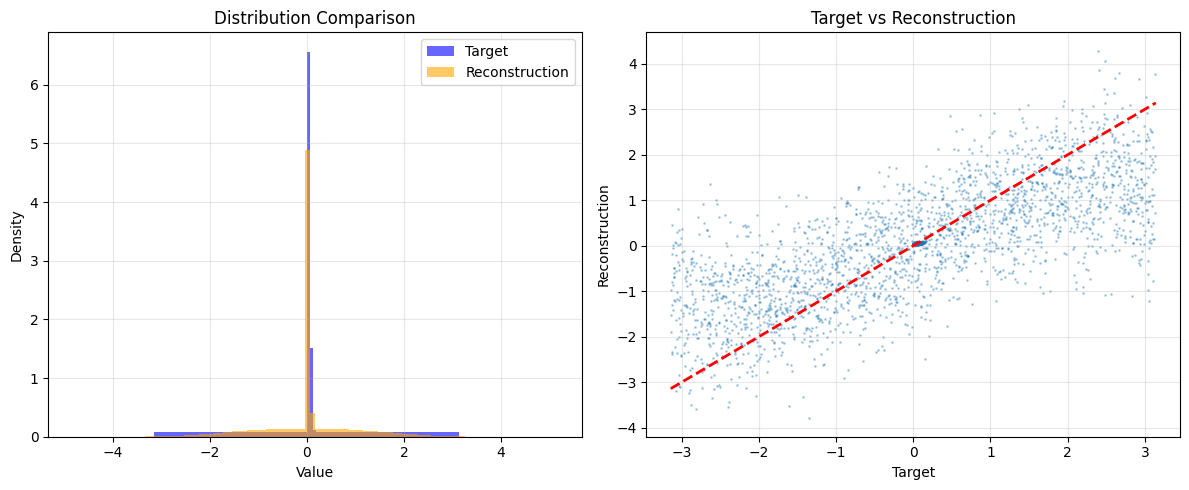

Target   - Mean: 0.0213, Std: 1.2819
Recon    - Mean: 0.0216, Std: 0.9143
MSE: 0.790993
Correlation: 0.7202


In [4]:
import matplotlib.pyplot as plt
import numpy as np
target = output['target'].detach().cpu().numpy().flatten()
recon = output['reconstruction'].detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(target, bins=100, alpha=0.6, label='Target', color='blue', density=True)
plt.hist(recon, bins=100, alpha=0.6, label='Reconstruction', color='orange', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter
plt.subplot(1, 2, 2)
sample_idx = np.random.choice(len(target), min(5000, len(target)), replace=False)
plt.scatter(target[sample_idx], recon[sample_idx], alpha=0.3, s=1)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', linewidth=2)
plt.xlabel('Target')
plt.ylabel('Reconstruction')
plt.title('Target vs Reconstruction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target   - Mean: {target.mean():.4f}, Std: {target.std():.4f}")
print(f"Recon    - Mean: {recon.mean():.4f}, Std: {recon.std():.4f}")
print(f"MSE: {np.mean((recon - target)**2):.6f}")
print(f"Correlation: {np.corrcoef(target, recon)[0, 1]:.4f}")